In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install libtiff
##!pip install MRCNN

     |████████████████████████████████| 133kB 5.0MB/s 
  Created wheel for libtiff: filename=libtiff-0.4.2-cp36-cp36m-linux_x86_64.whl size=280198 sha256=fa35f0c749b59e18f60a765f7e8b22e7e39d1ebcddaa65e2ec8f1fea3bc423b1
  Stored in directory: /root/.cache/pip/wheels/7c/ce/79/9c7115224f798f73bdbd2c23e06c6fa048adcca7041b9fd104
Successfully built libtiff


In [0]:
%cd /content/drive/My\ Drive/approach1_maskrcnn/Mask\ RCNN
!pwd

In [4]:
## Set matplotlib backend
# This has to be done before other importa that might
# set it, but only if we're running in script mode
# rather than being imported.
'''
if __name__ == '__main__':
    import matplotlib
    # Agg backend runs without a display
    matplotlib.use('Agg')
    import matplotlib.pyplot as plt
'''
import matplotlib.pyplot as plt
import os
import sys
import json
import datetime
import xlrd
import cv2
import tensorflow as tf
import numpy as np
import skimage.io
from imgaug import augmenters as iaa
from libtiff import TIFF, TIFFfile

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

# Results directory
# Save submission files here
RESULTS_DIR = os.path.join(ROOT_DIR, "results/cellcount/")

from MRCNN.config import Config
import MRCNN.model as modellib
from MRCNN import utils, visualize

DataSize=100
Validation_ratio=0.1
Data_IDS=np.arange(1,DataSize+1,dtype=np.int16) 
VAL_IMAGE_IDS = np.random.choice(Data_IDS,size=np.int(Validation_ratio*DataSize),replace=False)
VAL_IMAGE_IDS.sort()

#####################################################
#         Configuration
#####################################################
class CellCountConfig(Config):
    NAME = 'CellCount'
    
    # Train on 1 GPU and 2 images per GPU.
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    # Number of classes (including background)
    NUM_CLASSES = 1 + 1 # Background + RedBloodCell
    
    # Don't exclude based on confidence. Since we have two classes
    # then 0.5 is the minimum anyway as it picks between nucleus and BG
    DETECTION_MIN_CONFIDENCE = 0
    
    # Learning rate and momentum
    # The Mask RCNN paper uses lr=0.02, but on TensorFlow it causes
    # weights to explode. Likely due to differences in optimizer
    # implementation.
    LEARNING_RATE = 0.00005
    LEARNING_MOMENTUM = 0.9

  # Weight decay regularization
    WEIGHT_DECAY = 1e-5 # 0.0001

    # Optimizer, default is 'SGD'
    OPTIMIZER = 'ADAM'

    # Backbone network architecture
    # Supported values are: resnet50, resnet101
    BACKBONE = "resnet101"
    
    # Input image resizing
    IMAGE_RESIZE_MODE = "pad64"
    IMAGE_MIN_DIM = 812
    IMAGE_MAX_DIM = 1280
    IMAGE_SHAPE= (832, 1280, 3)
    
    IMAGE_CHANNEL_COUNT = 3   
    
    # Length of square anchor side in pixels
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    
    # Number of ROIs per image to feed to classifier/mask heads
    # The Mask RCNN paper uses 512 but often the RPN doesn't generate
    # enough positive proposals to fill this and keep a positive:negative
    # ratio of 1:3. You can increase the number of proposals by adjusting
    # the RPN NMS threshold.
    TRAIN_ROIS_PER_IMAGE = 256

    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 100

    # Max number of final detections per image
    DETECTION_MAX_INSTANCES = 200
    
    
    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100
    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
    
    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    #RPN_NMS_THRESHOLD = 0.9
    RPN_NMS_THRESHOLD=0.95
    
    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 500
    POST_NMS_ROIS_INFERENCE = 1000
    
    # Image mean (RGB)
    MEAN_PIXEL = (126,126,126)
        
    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution images.
    USE_MINI_MASK = True
    #MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask
    MINI_MASK_SHAPE = (100,100)

    # Loss weights for more precise optimization.
    # Can be used for R-CNN training setup.
    LOSS_WEIGHTS = {
        "rpn_class_loss": 1.,
        "rpn_bbox_loss": 1.,
        "mrcnn_class_loss": 1.,
        "mrcnn_bbox_loss": 1.,
        "mrcnn_mask_loss": 1.
    }

#####################################################
#         Dataset
#####################################################
class CellDataset(utils.Dataset):
    
    def Image_gen(self, FileName):
        self.frame=0
        self.ImgeFile=FileName
        tif=TIFF.open(FileName)
        for Image_gened in tif.iter_images():
        #Image = imread(FileName,1)
            self.frame+=1
            yield Image_gened  
    
    def Image_getFrame(self, Image_dir, Frame):
        #if self.ImgeFile!=Image_dir or self.frame > Frame:
        Image_gen=self.Image_gen(Image_dir)
        self.frame=0
        im_getFrame=[]
        while self.frame<Frame:
            im_getFrame= next(Image_gen)
        im_getFrame=np.array(im_getFrame)
        return im_getFrame
            
    def load_cells(self, dataset_dir, subset):
        """
        Load a subset of the cell dataset.
        dataset_dir: Root directory of the dataset
        subset: Subset to load. 
                * train: training data excluding validation images
                * val: validation images from VAL_IMAGE_IDS
        """

        # Add classes. We have one class.
        # Naming the dataset Cells, and the 1st class RedBloodCell
        self.add_class("Cells", 1, "RBC")
        ROOT_PATH=os.path.dirname(os.getcwd())
        dataset_dir=os.path.join(ROOT_PATH,"Data",dataset_dir)
       # Train or validation dataset?
        assert subset in ["train", "val", "pred"]
        if subset == "val":
            image_ids = VAL_IMAGE_IDS
       # Get image ids from directory names
        elif subset == "train":
            image_ids = list(set(Data_IDS) - set(VAL_IMAGE_IDS))
        elif subset == "pred": 
            image_ids = Data_IDS

        # Add images
        for image_id in image_ids:
            self.add_image(
                "Cells",
                image_id=image_id,
                path=dataset_dir)
                  
    def load_image (self,image_id, image_dir=None):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        info = self.image_info[image_id]
        dataset_dir=info['path']
        data=xlrd.open_workbook(os.path.join(dataset_dir,'cellLabel.xlsx'))
        data=data.sheets()[0]
        if not image_dir:
          Image_dir=os.path.join(os.path.dirname(os.getcwd()),data.col_values(0)[1])
          image=self.Image_getFrame(Image_dir, info['id'])
          # If grayscale. Convert to RGB for consistency.
          image=(image/np.max(image)*255).astype(np.float16)
          if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
          # If has an alpha channel, remove it for consistency
          if image.shape[-1] == 4:
            image = image[..., :3]
        else:
          Image_dir=image_dir
          image=self.Image_getFrame(Image_dir, info['id'])
        return image
        
    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        info = self.image_info[image_id]
        dataset_dir=info['path']
        data=xlrd.open_workbook(os.path.join(dataset_dir,'cellLabel.xlsx'))
        data=data.sheets()[0]
        Frame=data.col_values(1)[1:]
        ClassName=data.col_values(2)[1:]
        
        MaskNum=data.col_values(4)[1:]
        ImgMask = [(Class,ImgMask) for [Class,ImgMask,frame] in zip(ClassName, MaskNum,Frame) if frame==info['id']]
        # Read mask files from .tif image
        Mask=[]
        ClassID=[]
        for i,Img in enumerate(ImgMask):
            # Get mask directory from image path
            mask_dir = os.path.join(info['path'], "{}.tif".format(Img[1]))
            #ID=[name['id'] for name in (self.class_info) if name.get('name')==Img[0]]
            ID=1
            im = cv2.imread(mask_dir,0).astype(np.bool)
            Mask.append(im)
            ClassID.append(ID)
        Mask = np.stack(Mask, axis=-1)
        ClassID= np.squeeze(np.array(ClassID))
        return Mask,ClassID
    
    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "cells":
            return info["id"]
        else:
            super(self.__class__, self).image_reference(image_id)

############################################################
#  Training
############################################################

def train(model, dataset_dir, subset):
    """Train the model."""
    # Training dataset.
    dataset_train = CellDataset()
    dataset_train.load_cells(dataset_dir,"train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = CellDataset()
    dataset_val.load_cells(dataset_dir, "val")
    dataset_val.prepare()
    
    # Image augmentation
    # http://imgaug.readthedocs.io/en/latest/source/augmenters.html
    augmentation = iaa.SomeOf((0, 2), [
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.OneOf([iaa.Affine(rotate=90),
                   iaa.Affine(rotate=180),
                   iaa.Affine(rotate=270)]),
        iaa.Multiply((0.8, 1.5)),
        iaa.GaussianBlur(sigma=(0.0, 5.0))
    ])

    # If starting from imagenet, train heads only for a bit
    # since they have random weights
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                augmentation=augmentation,
                epochs=25,
                layers='4+')
    '''
    print("Train all layers")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=40,
                augmentation=augmentation,
                layers='all')
    '''

Using TensorFlow backend.


In [0]:
# Training step
if __name__ == '__main__':
    os.environ['CUDA_VISIBLE_DEVICES'] = "1"
    config = CellCountConfig()
    #config.display()

    # Create model
    model = modellib.MaskRCNN(mode="training", config=config, model_dir=RESULTS_DIR)

    #Load COCO weights
    COCO_WEIGHTS_PATH = os.path.join(os.path.dirname(ROOT_DIR), "mask_rcnn_coco.h5")
    weights_path= COCO_WEIGHTS_PATH
    #weights_path = model.get_imagenet_weights()
    # Load weights
    model.load_weights(weights_path, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
    #model.load_weights(weights_path, by_name=True)
    train(model=model, dataset_dir='val', subset='train')

In [5]:
############################################################
#  Detection
############################################################
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
config = CellCountConfig()

#Create Model
model = modellib.MaskRCNN(mode="inference", config=config, model_dir=RESULTS_DIR)

#Load weights
weights_path= "results/cellcount/cellcount20200425T2106/mask_rcnn_cellcount_0021.h5" # loading our trained model
# Load weights
model.load_weights(weights_path, by_name=True)

Re-starting from epoch 21


In [0]:
def compute_Dice(s1,s2):
  p = np.argwhere(s2 > 0)
  s2_n = np.zeros_like(s2)
  s2_n[p] = 1 # one of the cell masks in the last frame
  row, col = s2.shape[0], s2.shape[1]
  # s1: selected cell mask in the current frame
  s = []
  for r in range(row):
    for c in range(col):
      if s1[r][c] == s2_n[r][c]:
        s.append(s1[r][c])
  m1 = np.linalg.norm(s)
  m2 = np.linalg.norm(s1.flatten()) + np.linalg.norm(s2_n.flatten())
  d = 2*m1/m2
  return d

In [0]:
# the coordinates of the selected ROI generated from 'stabilization.ipynb'
cor_box = np.zeros((5,2))
cor_box[0,0], cor_box[0,1] = 530, 417
cor_box[1,0], cor_box[1,1] = 573, 398
cor_box[2,0], cor_box[2,1] = 491, 214
cor_box[3,0], cor_box[3,1] = 448, 233
cor_box[4,0], cor_box[4,1] = 530, 417
cor_box = cor_box[np.newaxis,:,:]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

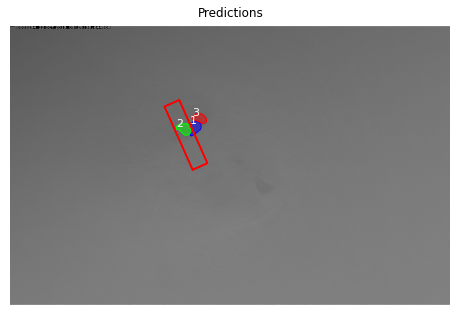

Frame ID  100
Counted Cell Number = 2
Double Counting Number = 2
Accumulative Cell Number = 52


In [10]:
# Read dataset
dataset = CellDataset()
dataset.load_cells('val', 'pred')
dataset.prepare()
im_dir='../stab_val.tif' # test data
import matplotlib
%matplotlib inline
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
  from IPython import display

GT_no=[]
DE_no=[]
tracking_list = []
cellCount_list = []
ACCU = []
for image_id in range(0,100):
  image = dataset.load_image(image_id, image_dir=im_dir)
  mask,class_id = dataset.load_mask(image_id)
  #image =dataset.Image_getFrame(im_dir,image_id)
  if image.ndim != 3:
    image = skimage.color.gray2rgb(image)
  # If has an alpha channel, remove it for consistency
  if image.shape[-1] == 4:
    image = image[..., :3]
  #image=(image/np.max(image)*255).astype(np.float16)
  # Detect objects
  r = model.detect([image], verbose=0)[0]
  # Encode image to RLE. Returns a string of multiple lines
  source_id = dataset.image_info[image_id]["id"]
  #rle = mask_to_rle(source_id, r["masks"], r["scores"])
  #submission.append(rle)
  GT_no.append(np.size(mask,2))
  DE_no.append(len(r['class_ids']))
  #print('--------------------------------')
  #print('image_id: ', image_id)
  #print('Frame ID =', dataset.image_info[image_id]["id"])
  #print('Ground Truth Cell Number = ', GT_no[-1])
  #print('Detected Cell Number =', DE_no[-1])
  #bg=np.zeros(np.shape(image))
  #plt.plot(cor_boxN[:,0],cor_boxN[:,1],color='red')
  if is_ipython:
    display.clear_output(wait=True)
    display.display(plt.gcf())
  cellCount, centroids, cell_idx, Contours = visualize.display_instances(
      image, r['rois'], r['masks'], r['class_ids'],
      dataset.class_names, r['scores'],
      captions=[cp for cp in range(1,DE_no[-1]+1)], show_bbox=False, show_mask=True, cellcount=True, countbox=cor_box, 
      figsize=(8, 8), title="Predictions")

  cellCount_list.append(cellCount)

  N = r['rois'].shape[0]
  ovl = 0
  if image_id == 0:
    centroids_o = [centroids[c] for c in cell_idx]
    masks_o = np.array([r['masks'][:,:,c] for c in cell_idx])
  elif image_id > 0:
    for n in cell_idx:
      mask_n = r['masks'][:,:,n]
      mmap = np.argwhere(mask_n > 0)
      mask_pre = np.zeros_like(mask_n)
      dice_list = []
      for n_o in range(len(centroids_o)):
        delta = centroids[n] - centroids_o[n_o]
        mmap_pre = mmap - np.int64(delta)
        mask_pre[mmap_pre] = 1
        dice = compute_Dice(mask_pre, masks_o[n_o,:,:])
        if dice > 0.7:
          dice_list.append(dice)
        if len(dice_list) >= 1:
          ovl += 1
          break
    centroids_o = [centroids[c] for c in cell_idx]
    masks_o = np.array([r['masks'][:,:,c] for c in cell_idx])

  if image_id == 0:
    accu_o = cellCount-ovl
    ACCU.append(accu_o)
  else:
    accu = cellCount-ovl
    accu_n = accu+accu_o
    ACCU.append(accu_n)
    accu_o = accu_n
  print('Frame ID ', image_id+1)
  print('Counted Cell Number =', cellCount), print('Double Counting Number =', ovl)
  print('Accumulative Cell Number =', ACCU[image_id])
  tracking_list.append([image_id,ovl])

Text(0, 0.5, 'Cell Number')

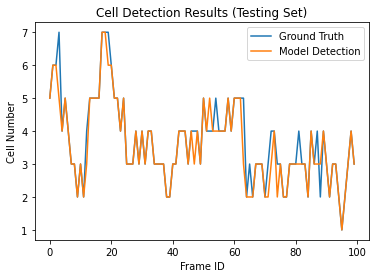

In [57]:
plt.title('Cell Detection Results (Testing Set)')
 
plt.plot(GT_no, label='Ground Truth')
plt.plot(DE_no, label='Model Detection')
plt.legend()
 
plt.xlabel('Frame ID')
plt.ylabel('Cell Number')


In [0]:
ACCU[49],ACCU[99] # show the accumulative cell number